In [ ]:
import pandas as pd

# Load your DataFrame
df = pd.read_csv('/content/drive/MyDrive/subset result.csv') # Example if your dataset is in a CSV file
df['item_7'] = df['item_7'].astype(str)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

train_df, val_df = train_test_split(df, test_size=0.2, random_state=29)

df_majority = train_df[train_df.high_30 == 1]
df_minority = train_df[train_df.high_30 == 0]

# Downsample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),     # to match minority class
                                   random_state=29) # reproducible results

# Combine minority class with downsampled majority class
train_df = pd.concat([df_majority_downsampled, df_minority])

train_df = resample(train_df,
                                   replace=False,    # sample without replacement
                                   n_samples=len(train_df),     # to match minority class
                                   random_state=29) # reproducible results

# Display new class counts
print(train_df.high_30.value_counts())

0    323
1    323
Name: high_30, dtype: int64


In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

def tokenize_function(examples):
    return tokenizer(examples['item_7'], padding='max_length', truncation=True, max_length=512)

train_dataset = train_df.apply(tokenize_function, axis=1)
val_dataset = val_df.apply(tokenize_function, axis=1)


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['high_30'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train = TextDataset(train_dataset, train_df['high_30'].tolist())
val = TextDataset(val_dataset, val_df['high_30'].tolist())

In [ ]:
train_attention_mask = []
train_input_ids = []
for element in train_dataset:
  train_attention_mask.append(element['attention_mask'])
  train_input_ids.append(element['input_ids'])

test_attention_mask = []
test_input_ids = []
for element in val_dataset:
  test_attention_mask.append(element['attention_mask'])
  test_input_ids.append(element['input_ids'])

In [ ]:
df_train = pd.DataFrame({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_mask,
    'labels': train.labels
})

df_test = pd.DataFrame({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_mask,
    'labels': val.labels
})

In [ ]:
dataset = []
for _, row in df_train.iterrows():
    # Creating a dictionary for each row
    data_point = {
        'input_ids': torch.tensor(row['input_ids']),  # Convert to tensor
        'attention_mask': torch.tensor(row['attention_mask']),  # Convert to tensor
        'labels': row['labels']  # Assuming labels are already in the correct format
    }
    dataset.append(data_point)

test_dataset = []
for _, row in df_test.iterrows():
    # Creating a dictionary for each row
    data_point = {
        'input_ids': torch.tensor(row['input_ids']),  # Convert to tensor
        'attention_mask': torch.tensor(row['attention_mask']),  # Convert to tensor
        'labels': row['labels']  # Assuming labels are already in the correct format
    }
    test_dataset.append(data_point)

In [ ]:
def create_batches(dataset, batch_size):
    batches = []
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i + batch_size]
        batch_input_ids = torch.stack([item['input_ids'] for item in batch])
        batch_attention_mask = torch.stack([item['attention_mask'] for item in batch])
        batch_labels = torch.tensor([item['labels'] for item in batch])

        batches.append({
            'input_ids': batch_input_ids,
            'attention_mask': batch_attention_mask,
            'labels': batch_labels
        })
    return batches

# Example usage
batch_size = 4
batches = create_batches(dataset, batch_size)
test_batches = create_batches(test_dataset, batch_size)

In [ ]:
# Model and optimizer
from transformers import AdamW, DistilBertForSequenceClassification

actual_labels_train = train_df['high_30'].to_list()
actual_labels_val = val_df['high_30'].to_list()

train_loss_list = []
val_loss_list = []

for lr in [1e-5]:
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-cased',
        output_hidden_states=True,
        seq_classif_dropout=0.2)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Number of training epochs
    num_epochs = 8

    # Training loop

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        all_predictions = []

        for batch in batches:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predicted_labels = outputs.logits.argmax(dim=1)
            all_predictions.extend(predicted_labels.tolist())
            # print(predicted_labels)

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(batches)
        train_loss.append(avg_train_loss)
        print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels_train, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels_train)
        print("Accuracy:", accuracy)

        # Validation loop
        model.eval()
        total_eval_loss = 0
        all_predictions = []
        for batch in test_batches:
            with torch.no_grad():
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                labels = batch['labels']

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                predicted_labels = outputs.logits.argmax(dim=1)
                all_predictions.extend(predicted_labels.tolist())

                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(test_batches)
        val_loss.append(avg_val_loss)
        print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")

        correct_predictions = sum(a == p for a, p in zip(actual_labels_val, all_predictions))

        # Calculate accuracy
        accuracy = correct_predictions / len(actual_labels_val)
        print("Accuracy:", accuracy)
        print(all_predictions)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Average Training Loss: 0.683742321383806
Accuracy: 0.5541795665634675
Epoch 0: Average Validation Loss: 0.6340757459402084
Accuracy: 0.695
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Epoch 1: Average Training Loss: 0.633160989501594
Accuracy: 0.6594427244582043
Epoch 1: Average Validation Loss: 0.6252177679538726
Accuracy: 0.71
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1

KeyboardInterrupt: ignored

In [ ]:
true_labels = val_df['high_30'].tolist()

In [ ]:
predicted_labels = all_predictions

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate Precision
precision = precision_score(true_labels, predicted_labels)

# Calculate Recall
recall = recall_score(true_labels, predicted_labels)

# Calculate F1 Score
f1 = f1_score(true_labels, predicted_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7150
Precision: 0.7500
Recall: 0.8160
F1 Score: 0.7816


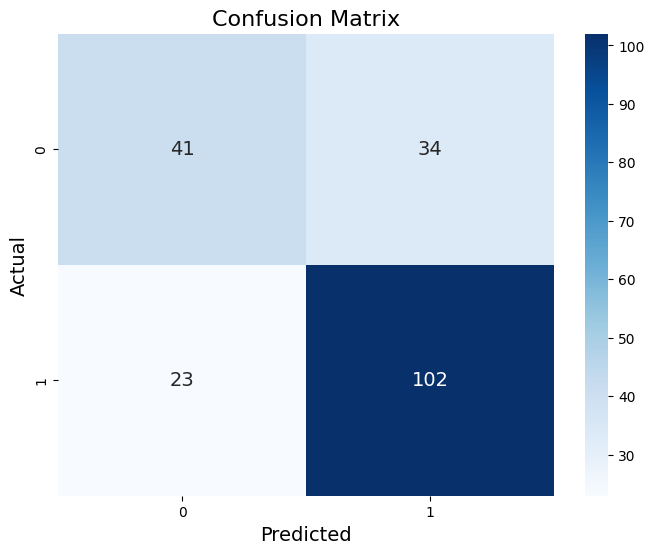

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()
